In [18]:
import pandas as pd
import requests
import re
import os
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import google.generativeai as genai
from dotenv import load_dotenv
import numpy as np
from sentence_transformers import SentenceTransformer, util
from bert_score import score as bert_score

# For RAG
import fitz
import chromadb
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from rank_bm25 import BM25Okapi

## 1. Load and preprocess data (dev-test split) ##

In [ ]:
df_raw = pd.read_excel("Independent Study Dataset.xlsx", header=None)
headers = df_raw.iloc[0]
data   = df_raw[1:].copy()
data.columns = headers

In [ ]:
min_test_samples = 2
test_size = 0.4

# Ensure stratified split
train_df, test_df = train_test_split(
    data,
    test_size=test_size,
    stratify=data["Test"],
    random_state=42
)

# Check if every class has at least 2 samples in test set
counts = test_df["Test"].value_counts()
if (counts < min_test_samples).any():
    print("⚠️ Not enough samples per class in test set.")

# Save splits
train_df.to_csv("outputs/dev_set.csv", index=False)
test_df.to_csv("outputs/test_set.csv", index=False)

print("Test set distribution:\n", test_df["Test"].value_counts())

## 2. llama-3.2-3b-instruct Workflow ##

In [10]:
API_BASE = "http://localhost:1234/v1"
MODEL    = "llama-3.2-3b-instruct"

In [14]:
# Function to answer a question using the LLaMA model (sent throught LMStudio API)
def answer_question(scenario):
    # Construct prompt
    prompt_lines = [
        "You are a helpful assistant that suggests statistical test based on provided research scenario.",
        "TASK: Given the following research scenario, suggest the most appropriate statistical test. ", 
        "The test must be one of the following: one-sample t-test, two-sample t-test, ANOVA, Chi-square test, paired t-test, multiple linear regression, logistic regression.",
        f"SCENARIO: {scenario}",
        "NOTE: Your response should include consideration of assumptions and conditions for each test.",
        "Show your step-by-step reasoning and then on its own line, output exactly: 'Final Answer: <test name>'.",
    ]
    prompt = "\n".join(prompt_lines)

    print("Prompt:\n", prompt)

    # Call model via API
    payload = {
        "model": MODEL,
        "messages": [{"role": "user", "content": prompt}],
    }
    resp = requests.post(
        f"{API_BASE}/chat/completions",
        json=payload,
        headers={"Content-Type": "application/json"}
    )
    resp.raise_for_status()
    raw = resp.json()["choices"][0]["message"]["content"].strip()

    # Extract final answer using regex
    match = re.search(r"Final Answer:\s*(.*)", raw)
    if match:
        test_name = match.group(1).strip()
        test_name = re.sub(r"[\*\.]+$", "", test_name)
        test_name = re.sub(r"^[\s\*'\"]+", "", test_name)
        test_name = test_name.lower()
    else:
        test_name = "Unknown"
        print("Warning: 'Final Answer' not found in the model's response.")

    return raw, test_name

In [15]:
# Loop over each scenario and get model's answer
data = pd.read_csv("outputs/dev_set.csv")

results = []

for idx, row in data.iterrows():
    scenario   = row["Scenario"]
    true_label = row["Test"]

    justification, model_answer = answer_question(scenario)

    results.append({
        "Scenario": scenario,
        "True_Answer": true_label,
        "Model_Justification": justification,
        "Model_Answer": model_answer
    })

# Save results
out_df = pd.DataFrame(results)
out_path = "outputs/dev_results_llama_3B_prompt_1.csv"
out_df.to_csv(out_path, index=False)

print("Saved results to ", out_path)

Prompt:
 You are a helpful assistant that suggests statistical test based on provided research scenario.
TASK: Given the following research scenario, suggest the most appropriate statistical test. 
The test must be one of the following: one-sample t-test, two-sample t-test, ANOVA, Chi-square test, paired t-test, multiple linear regression, logistic regression.
SCENARIO: Undergraduate students taking an introductory statistics course at Duke University conducted a survey about GPA and major. Given box plots show the distribution of GPA among three groups of majors. What test for testing for a difference between average GPA across majors?
NOTE: Your response should include consideration of assumptions and conditions for each test.
Show your step-by-step reasoning and then on its own line, output exactly: 'Final Answer: <test name>'.


KeyboardInterrupt: 

Overall Accuracy: 71.74%

Per-Class Performance:
                            precision    recall  f1-score   support

                     anova      0.875     1.000     0.933         7
           chi-square test      0.667     0.667     0.667         6
                    f-test      0.000     0.000     0.000         0
       logistic regression      0.500     0.333     0.400         6
multiple linear regression      0.800     0.667     0.727         6
         one-sample t-test      1.000     0.857     0.923         7
             paired t-test      1.000     0.625     0.769         8
  single-proportion z-test      0.000     0.000     0.000         0
         two-sample t-test      0.500     0.833     0.625         6

                  accuracy                          0.717        46
                 macro avg      0.594     0.554     0.561        46
              weighted avg      0.781     0.717     0.732        46



/Users/hpanh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hpanh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hpanh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


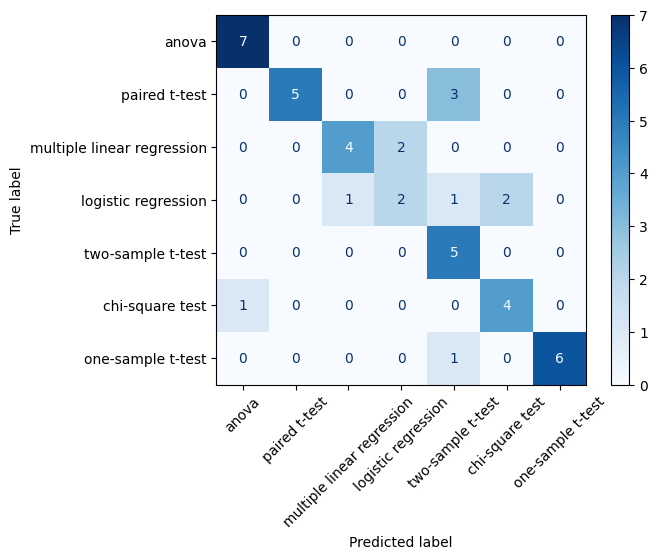

In [16]:
# Result evaluation (prompt 1)
df = pd.read_csv("outputs/dev_results_llama_3B_prompt_1.csv")
df["True_Answer"] = df["True_Answer"].str.lower().str.replace(r"[\*\.]+$", "", regex=True)
df["Model_Answer"] = df["Model_Answer"].str.lower().str.replace(r"[\*\.]+$", "", regex=True)

# Overall accuracy
overall_acc = accuracy_score(df["True_Answer"], df["Model_Answer"])
print(f"Overall Accuracy: {overall_acc:.2%}")

# Accuracy per class
print("\nPer-Class Performance:")
print(classification_report(df["True_Answer"], df["Model_Answer"], digits=3))

# Confusion matrix
cm = confusion_matrix(df["True_Answer"], df["Model_Answer"], labels=df["True_Answer"].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df["True_Answer"].unique())
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

Overall Accuracy: 73.91%

Per-Class Performance:
                            precision    recall  f1-score   support

                     anova      1.000     0.857     0.923         7
           chi-square test      0.714     0.833     0.769         6
                    f-test      0.000     0.000     0.000         0
     kruskal-wallis h-test      0.000     0.000     0.000         0
       logistic regression      1.000     0.667     0.800         6
       mann-whitney u test      0.000     0.000     0.000         0
multiple linear regression      1.000     1.000     1.000         6
     one-proportion z-test      0.000     0.000     0.000         0
         one-sample t-test      1.000     0.571     0.727         7
             paired t-test      0.857     0.857     0.857         7
                    t-test      0.000     0.000     0.000         0
         two-sample t-test      0.600     0.429     0.500         7
              z-score test      0.000     0.000     0.000         

/Users/hpanh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hpanh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hpanh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


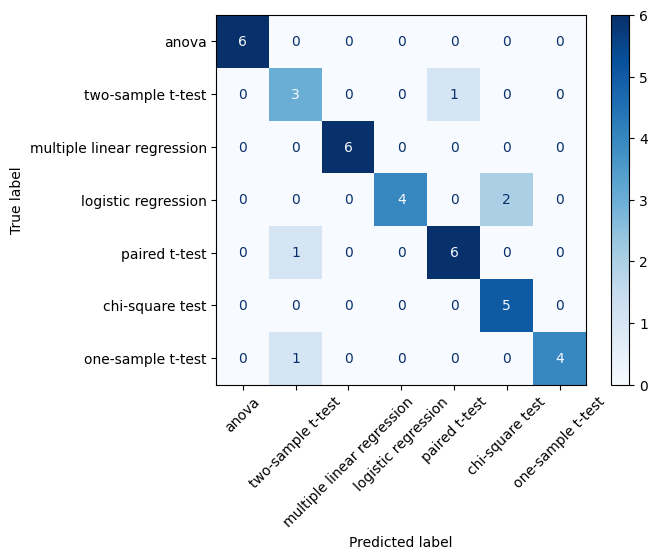

In [5]:
# Result evaluation (prompt 2)
df = pd.read_csv("outputs/dev_results_llama_3B_prompt_2.csv")
df["True_Answer"] = df["True_Answer"].str.lower().str.replace(r"[\*\.]+$", "", regex=True)
df["Model_Answer"] = df["Model_Answer"].str.lower().str.replace(r"[\*\.]+$", "", regex=True)

# Overall accuracy
overall_acc = accuracy_score(df["True_Answer"], df["Model_Answer"])
print(f"Overall Accuracy: {overall_acc:.2%}")

# Accuracy per class
print("\nPer-Class Performance:")
print(classification_report(df["True_Answer"], df["Model_Answer"], digits=3))

# Confusion matrix
cm = confusion_matrix(df["True_Answer"], df["Model_Answer"], labels=df["True_Answer"].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df["True_Answer"].unique())
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

## 2. llama-3.1-8b-instruct Workflow ##

In [ ]:
API_BASE = "http://localhost:1234/v1"
MODEL    = "meta-llama-3.1-8b-instruct"

In [ ]:
# Function to answer a question using the LLaMA model (sent throught LMStudio API)
def answer_question(scenario):
    # Construct prompt
    prompt_lines = [
        "You are a helpful assistant that suggests statistical test based on provided research scenario.",
        "TASK: Given the following research scenario, suggest the most appropriate statistical test. ", 
        # "The test must be one of the following: one-sample t-test, two-sample t-test, ANOVA, Chi-square test, paired t-test, multiple linear regression, logistic regression.",
        f"SCENARIO: {scenario}",
        "NOTE: Your response should include consideration of assumptions and conditions for each test.",
        "Show your step-by-step reasoning and then on its own line, output exactly: 'Final Answer: <test name>'.",
    ]
    prompt = "\n".join(prompt_lines)

    # Call model via API
    payload = {
        "model": MODEL,
        "messages": [{"role": "user", "content": prompt}],
    }
    resp = requests.post(
        f"{API_BASE}/chat/completions",
        json=payload,
        headers={"Content-Type": "application/json"}
    )
    resp.raise_for_status()
    raw = resp.json()["choices"][0]["message"]["content"].strip()

    # Extract final answer using regex
    match = re.search(r"Final Answer:\s*(.*)", raw)
    if match:
        test_name = match.group(1).strip()
        test_name = re.sub(r"[\*\.]+$", "", test_name)
        test_name = re.sub(r"^[\s\*'\"]+", "", test_name)
        test_name = test_name.lower()
    else:
        test_name = "Unknown"
        print("Warning: 'Final Answer' not found in the model's response.")

    return raw, test_name

In [ ]:
# Loop over each scenario and get model's answer
data = pd.read_csv("outputs/dev_set.csv")

results = []

for idx, row in data.iterrows():
    scenario   = row["Scenario"]
    true_label = row["Test"]

    justification, model_answer = answer_question(scenario)

    results.append({
        "Scenario": scenario,
        "True_Answer": true_label,
        "Model_Justification": justification,
        "Model_Answer": model_answer
    })

# Save results
out_df = pd.DataFrame(results)
out_path = "outputs/dev_results_llama_8B_prompt_2.csv"
out_df.to_csv(out_path, index=False)

print("Saved results to ", out_path)

Overall Accuracy: 80.43%

Per-Class Performance:
                            precision    recall  f1-score   support

                     anova      0.875     1.000     0.933         7
           chi-square test      0.750     1.000     0.857         6
       logistic regression      1.000     0.833     0.909         6
multiple linear regression      1.000     0.833     0.909         6
         one-sample t-test      0.857     0.857     0.857         7
             paired t-test      0.714     0.714     0.714         7
         two-sample t-test      0.500     0.429     0.462         7

                  accuracy                          0.804        46
                 macro avg      0.814     0.810     0.806        46
              weighted avg      0.807     0.804     0.800        46



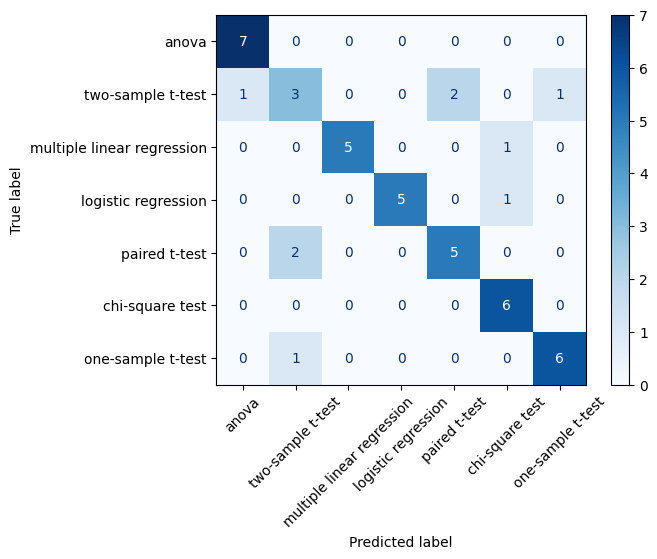

In [3]:
# Result evaluation (8B)
df = pd.read_csv("outputs/dev_results_llama_8B_prompt_1.csv")
df["True_Answer"] = df["True_Answer"].str.lower().str.replace(r"[\*\.]+$", "", regex=True)
df["Model_Answer"] = df["Model_Answer"].str.lower().str.replace(r"[\*\.]+$", "", regex=True)

# Overall accuracy
overall_acc = accuracy_score(df["True_Answer"], df["Model_Answer"])
print(f"Overall Accuracy: {overall_acc:.2%}")

# Accuracy per class
print("\nPer-Class Performance:")
print(classification_report(df["True_Answer"], df["Model_Answer"], digits=3))

# Confusion matrix
cm = confusion_matrix(df["True_Answer"], df["Model_Answer"], labels=df["True_Answer"].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df["True_Answer"].unique())
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

Overall Accuracy: 41.30%

Per-Class Performance:
                                                                              precision    recall  f1-score   support

                                                                       anova      0.800     0.571     0.667         7
                             anova followed by tukey's hsd or scheffé's test      0.000     0.000     0.000         0
                          anova with levene's test for equality of variances      0.000     0.000     0.000         0
                                                             chi-square test      0.333     0.167     0.222         6
                                                            chi-squared test      0.000     0.000     0.000         0
                                                        correlation analysis      0.000     0.000     0.000         0
                                                    levene's f-test (f-test)      0.000     0.000     0.000         0
      

/Users/hpanh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hpanh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hpanh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


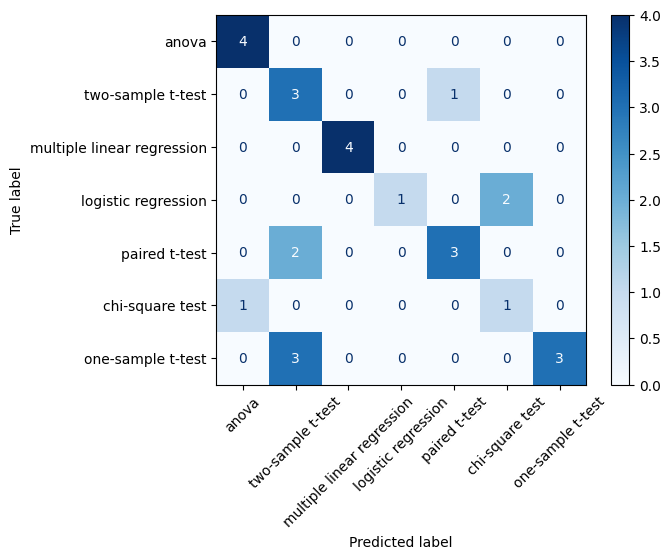

In [4]:
# Result evaluation (8B)
df = pd.read_csv("outputs/dev_results_llama_8B_prompt_2.csv")
df["True_Answer"] = df["True_Answer"].str.lower().str.replace(r"[\*\.]+$", "", regex=True)
df["Model_Answer"] = df["Model_Answer"].str.lower().str.replace(r"[\*\.]+$", "", regex=True)

# Overall accuracy
overall_acc = accuracy_score(df["True_Answer"], df["Model_Answer"])
print(f"Overall Accuracy: {overall_acc:.2%}")

# Accuracy per class
print("\nPer-Class Performance:")
print(classification_report(df["True_Answer"], df["Model_Answer"], digits=3))

# Confusion matrix
cm = confusion_matrix(df["True_Answer"], df["Model_Answer"], labels=df["True_Answer"].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df["True_Answer"].unique())
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

## 3. Gemini 2.5 Flash ##

In [ ]:
load_dotenv()
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
MODEL = "gemini-2.5-flash" 

In [ ]:
# Helper function to extract final answer from model output
def extract_final_answer(raw: str) -> str:
    patterns = [
        r"Final Answer:\s*(.*)",                
        r"\$\\boxed\{\\text\{(.*)\}\}\$",       
        r"\\boxed\{(.*)\}",                      
    ]

    for pat in patterns:
        match = re.search(pat, raw, flags=re.IGNORECASE)
        if match:
            test_name = match.group(1).strip()
            test_name = re.sub(r"[\*\.]+$", "", test_name)
            test_name = re.sub(r"^[\s\*'\"]+", "", test_name)
            return test_name.lower()

    print("Warning: could not parse final answer from response.")
    return "unknown"

In [ ]:
def answer_question(scenario):
    # Construct prompt
    prompt_lines = [
        "You are a helpful assistant that suggests statistical test based on provided research scenario.",
        "TASK: Given the following research scenario, suggest the most appropriate statistical test. ",
        # "The test must be one of the following: one-sample t-test, two-sample t-test, ANOVA, Chi-square test, paired t-test, multiple linear regression, logistic regression.",
        f"SCENARIO: {scenario}",
        "NOTE: Your response should include consideration of assumptions and conditions for each test.",
        "Show your step-by-step reasoning and then on its own line, output exactly: 'Final Answer: <test name>'.",
    ]
    prompt = "\n".join(prompt_lines)
    
    model = genai.GenerativeModel(MODEL)
    resp = model.generate_content(prompt)

    raw = resp.text.strip()

    # print(raw)
    # print("-----")

    test_name = extract_final_answer(raw)

    return raw, test_name

In [ ]:
# Loop over each scenario and get model's answer
data = pd.read_csv("outputs/dev_set.csv")

results = []

for idx, row in data.iterrows():
    scenario   = row["Scenario"]
    true_label = row["Test"]

    justification, model_answer = answer_question(scenario)

    results.append({
        "Scenario": scenario,
        "True_Answer": true_label,
        "Model_Justification": justification,
        "Model_Answer": model_answer
    })

out_df = pd.DataFrame(results)
out_path = "outputs/dev_results_gemini_prompt_2.csv"
out_df.to_csv(out_path, index=False)

print("Saved results to ", out_path)

Overall Accuracy: 91.30%

Per-Class Performance:
                            precision    recall  f1-score   support

                     anova      1.000     1.000     1.000         7
           chi-square test      0.667     1.000     0.800         6
       logistic regression      1.000     0.667     0.800         6
multiple linear regression      1.000     1.000     1.000         6
         one-sample t-test      1.000     1.000     1.000         7
             paired t-test      0.875     1.000     0.933         7
         two-sample t-test      1.000     0.714     0.833         7

                  accuracy                          0.913        46
                 macro avg      0.935     0.912     0.910        46
              weighted avg      0.938     0.913     0.912        46



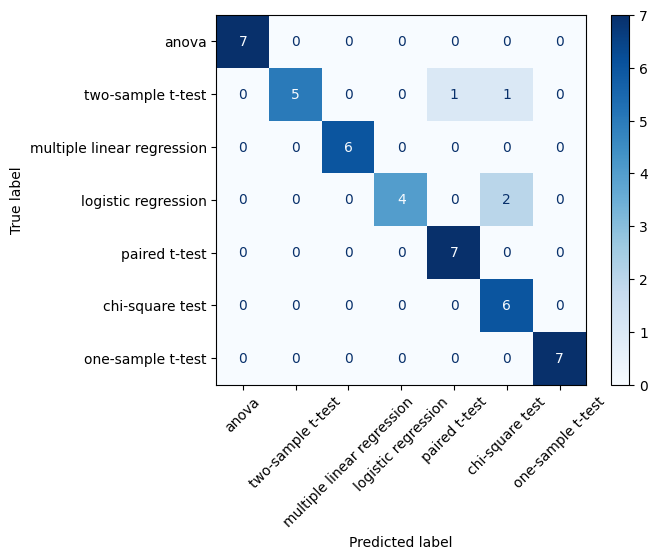

In [17]:
# Result evaluation
df = pd.read_csv("outputs/dev_results_gemini_prompt_1.csv")

# Overall accuracy
overall_acc = accuracy_score(df["True_Answer"], df["Model_Answer"])
print(f"Overall Accuracy: {overall_acc:.2%}")

# Accuracy per class
print("\nPer-Class Performance:")
print(classification_report(df["True_Answer"], df["Model_Answer"], digits=3))

# Confusion matrix
cm = confusion_matrix(df["True_Answer"], df["Model_Answer"], labels=df["True_Answer"].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df["True_Answer"].unique())
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

Overall Accuracy: 84.78%

Per-Class Performance:
                                      precision    recall  f1-score   support

                               anova      1.000     1.000     1.000         7
                     chi-square test      0.667     1.000     0.800         6
 cox proportional hazards regression      0.000     0.000     0.000         0
f-test for equality of two variances      0.000     0.000     0.000         0
                   linear regression      0.000     0.000     0.000         0
                 logistic regression      1.000     0.333     0.500         6
          multiple linear regression      1.000     0.833     0.909         6
                   one-sample t-test      1.000     0.857     0.923         7
                       paired t-test      1.000     1.000     1.000         8
                   two-sample t-test      1.000     0.833     0.909         6
                 z-score calculation      0.000     0.000     0.000         0

             

/Users/hpanh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hpanh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hpanh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


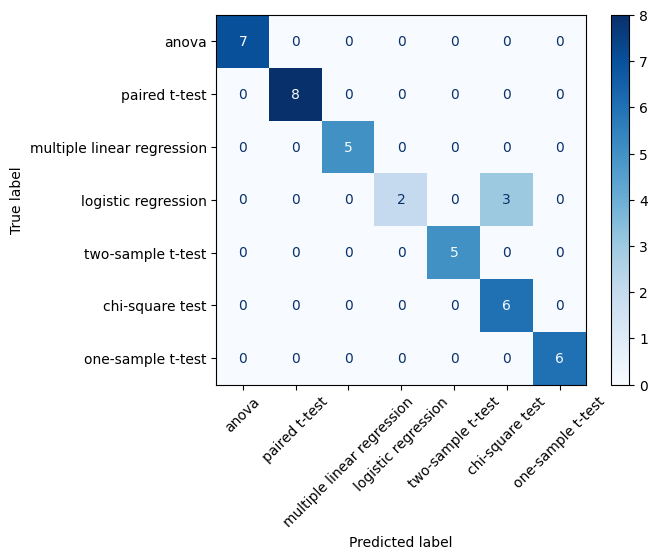

In [18]:
# Result evaluation
df = pd.read_csv("outputs/dev_results_gemini_prompt_2.csv")

# Overall accuracy
overall_acc = accuracy_score(df["True_Answer"], df["Model_Answer"])
print(f"Overall Accuracy: {overall_acc:.2%}")

# Accuracy per class
print("\nPer-Class Performance:")
print(classification_report(df["True_Answer"], df["Model_Answer"], digits=3))

# Confusion matrix
cm = confusion_matrix(df["True_Answer"], df["Model_Answer"], labels=df["True_Answer"].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df["True_Answer"].unique())
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

## 4. RAG ##

In [2]:
# Load, chunk, and embed textbook

def load_pdf_text(pdf_path):
    doc = fitz.open(pdf_path)
    full_text = "\n".join(page.get_text("text").strip() for page in doc)
    return full_text

def semantic_chunk_text(text, chunk_size=800, overlap=100):
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap)
    return splitter.split_text(text)

pdf_path = "textbook (shortened).pdf"
full_text = load_pdf_text(pdf_path)
chunks = semantic_chunk_text(full_text, chunk_size=800, overlap=100)

embedder = SentenceTransformer("thenlper/gte-large", device="mps")
dense_embs = embedder.encode(chunks, normalize_embeddings=True)

tokenized_corpus = [chunk.lower().split() for chunk in chunks]
bm25 = BM25Okapi(tokenized_corpus)

In [3]:
def hybrid_retrieve(query, top_k=2, k_rrf=60):
    qv = embedder.encode([query], normalize_embeddings=True)[0]
    dense_scores = np.dot(dense_embs, qv)
    dense_rank = dense_scores.argsort()[::-1]

    sparse_scores = bm25.get_scores(query.lower().split())
    sparse_rank = sparse_scores.argsort()[::-1]

    combined_scores = np.zeros(len(chunks))
    for rank_list in [dense_rank, sparse_rank]:
        for r, idx in enumerate(rank_list[:50]):
            combined_scores[idx] += 1.0 / (k_rrf + r + 1)

    top_idx = np.argsort(-combined_scores)[:top_k]
    return [chunks[i] for i in top_idx]

In [4]:
API_BASE = "http://localhost:1234/v1"
MODEL = "llama-3.2-3b-instruct"

def answer_question_with_rag(scenario):
    retrieved = hybrid_retrieve(scenario)
    context = "\n\n".join(retrieved)

    prompt = f"""
You are a statistics assistant helping select the correct statistical test.
The test must be one of the following: one-sample t-test, two-sample t-test, ANOVA, Chi-square test, paired t-test, multiple linear regression, logistic regression.
Use the retrieved textbook excerpts *if they are clearly relevant*. Otherwise, reason from principles.

CONTEXT:
{context}

QUESTION:
{scenario}

Your response should include consideration of assumptions and conditions for each test. Finally, on a new line write exactly:
Final Answer: <test name>
"""
    
    print(prompt)
    print("-----")

    payload = {
        "model": MODEL,
        "messages": [{"role": "user", "content": prompt}],
    }

    resp = requests.post(
        f"{API_BASE}/chat/completions",
        json=payload,
        headers={"Content-Type": "application/json"}
    )

    try:
        data = resp.json()
        raw = data["choices"][0]["message"]["content"].strip()
    except Exception as e:
        print("⚠️ Request failed or invalid response:", e)
        print("Raw response:", resp.text[:500])
        return "Error: no valid response", "unknown"

    match = re.search(r"Final Answer:\s*(.*)", raw)
    test_name = match.group(1).strip().lower() if match else "unknown"

    return raw, test_name

In [ ]:
data = pd.read_csv("outputs/dev_set.csv")
results = []
for _, row in data.iterrows():
    scenario   = row["Scenario"]
    true_label = row["Test"]
    justification, model_answer = answer_question_with_rag(scenario)
    results.append({
        "Scenario": scenario,
        "True_Answer": true_label,
        "Model_Justification": justification,
        "Model_Answer": model_answer
    })
out_df = pd.DataFrame(results)
out_df.to_csv("outputs/dev_results_rag_2_3B.csv", index=False)

In [ ]:
# ver 2: options given
data = pd.read_csv("outputs/dev_set.csv")
results = []
for _, row in data.iterrows():
    scenario   = row["Scenario"]
    true_label = row["Test"]
    justification, model_answer = answer_question_with_rag(scenario)
    results.append({
        "Scenario": scenario,
        "True_Answer": true_label,
        "Model_Justification": justification,
        "Model_Answer": model_answer
    })
out_df = pd.DataFrame(results)
out_df.to_csv("outputs/dev_results_rag_2_3B.csv", index=False)

Overall Accuracy: 54.35%

Per-Class Performance:
                                                          precision    recall  f1-score   support

                                                   anova      0.571     0.571     0.571         7
                                         chi-square test      0.667     1.000     0.800         6
                                                  f-test      0.000     0.000     0.000         0
                          generalized linear model (glm)      0.000     0.000     0.000         0
generalized linear model (glm) with poisson distribution      0.000     0.000     0.000         0
                                   kruskal-wallis h-test      0.000     0.000     0.000         0
                                     logistic regression      1.000     0.333     0.500         6
                                     mann-whitney u test      0.000     0.000     0.000         0
                         multinomial logistic regression      0.000 

/Users/hpanh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hpanh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hpanh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


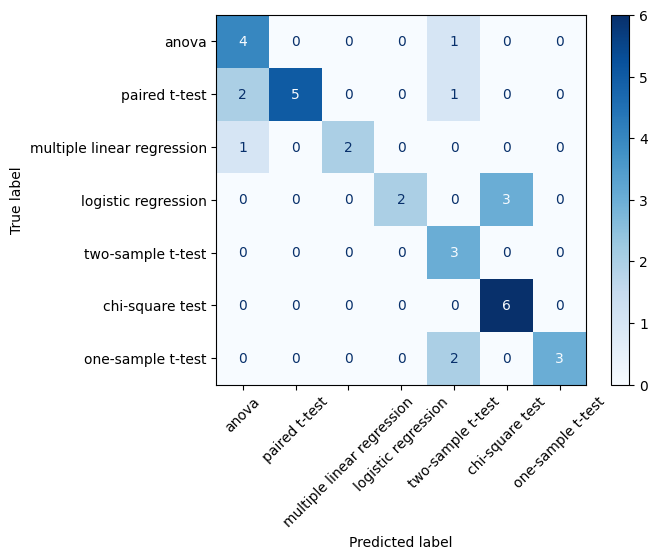

In [9]:
# Result evaluation
df = pd.read_csv("outputs/dev_results_rag_2_without_options_3B.csv")

# Overall accuracy
overall_acc = accuracy_score(df["True_Answer"], df["Model_Answer"])
print(f"Overall Accuracy: {overall_acc:.2%}")

# Accuracy per class
print("\nPer-Class Performance:")
print(classification_report(df["True_Answer"], df["Model_Answer"], digits=3))

# Confusion matrix
cm = confusion_matrix(df["True_Answer"], df["Model_Answer"], labels=df["True_Answer"].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df["True_Answer"].unique())
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

Overall Accuracy: 71.74%

Per-Class Performance:
                                  precision    recall  f1-score   support

                           anova      0.857     0.857     0.857         7
                 chi-square test      0.667     1.000     0.800         6
f-test for equality of variances      0.000     0.000     0.000         0
             logistic regression      0.667     0.333     0.444         6
      multiple linear regression      0.800     0.667     0.727         6
               one-sample t-test      1.000     0.857     0.923         7
                   paired t-test      0.857     0.750     0.800         8
               two-sample t-test      0.375     0.500     0.429         6

                        accuracy                          0.717        46
                       macro avg      0.653     0.621     0.623        46
                    weighted avg      0.759     0.717     0.723        46



/Users/hpanh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hpanh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hpanh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


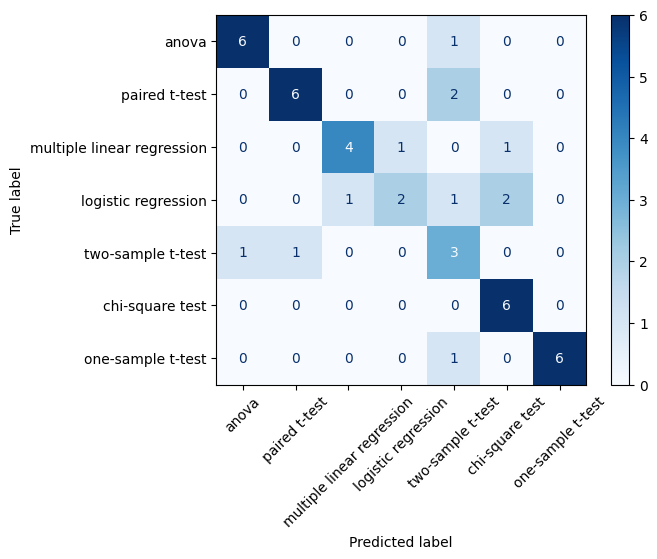

In [8]:
# Result evaluation
df = pd.read_csv("outputs/dev_results_rag_2_with_options_3B.csv")

# Overall accuracy
overall_acc = accuracy_score(df["True_Answer"], df["Model_Answer"])
print(f"Overall Accuracy: {overall_acc:.2%}")

# Accuracy per class
print("\nPer-Class Performance:")
print(classification_report(df["True_Answer"], df["Model_Answer"], digits=3))

# Confusion matrix
cm = confusion_matrix(df["True_Answer"], df["Model_Answer"], labels=df["True_Answer"].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df["True_Answer"].unique())
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

## Automated Evaluation (Cosine Similarity) ##

In [19]:
# Read data
file_path = "Independent Study Evaluation (Correct Classification).xlsx"
gold_df = pd.read_excel(file_path, sheet_name="Gold Answers")
just_df = pd.read_excel(file_path, sheet_name="Justifications")

# Map gold answers
gold_map = dict(zip(gold_df["Scenario"], gold_df["Gold Answer"]))
embedder = SentenceTransformer("thenlper/gte-large")

# Compute cosine similarity and scale 0–6
models = [
    "3B MCQ",
    "3B No MCQ",
    "8B MCQ",
    "8B No MCQ",
    "Gemini No MCQ",
    "3B + RAG"
]

auto_scores = []

for _, row in just_df.iterrows():
    scenario = row["Scenario"]
    gold = str(gold_map.get(scenario, "")).strip()
    if not gold:
        continue

    gold_emb = embedder.encode(gold, normalize_embeddings=True)
    result_row = {"Scenario": scenario}

    for model in models:
        pred = str(row.get(model, "")).strip()
        if not pred:
            result_row[model] = np.nan
            continue

        pred_emb = embedder.encode(pred, normalize_embeddings=True)
        cos_sim = util.cos_sim(gold_emb, pred_emb).item()
        result_row[model] = round(cos_sim, 2)

    auto_scores.append(result_row)

# Save results
auto_df = pd.DataFrame(auto_scores)
auto_df.to_csv("Independent_Study_Automated_Scores.csv", index=False)

## Automated Evaluation (BERTScore) ##

In [20]:
file_path = "Independent Study Evaluation (Correct Classification).xlsx"
gold_df = pd.read_excel(file_path, sheet_name="Gold Answers")
just_df = pd.read_excel(file_path, sheet_name="Justifications")

gold_map = dict(zip(gold_df["Scenario"], gold_df["Gold Answer"]))

models = [
    "3B MCQ",
    "3B No MCQ",
    "8B MCQ",
    "8B No MCQ",
    "Gemini No MCQ",
    "3B + RAG"
]

results = []

for _, row in just_df.iterrows():
    scenario = str(row["Scenario"]).strip()
    gold = str(gold_map.get(scenario, "")).strip()

    result_row = {"Scenario": scenario}

    for model in models:
        pred = str(row.get(model, "")).strip()

        # Compute BERTScore 
        P, R, F1 = bert_score(
            [pred],
            [gold],
            model_type="microsoft/deberta-xlarge-mnli",
            lang="en",
            rescale_with_baseline=False
        )

        # Normalize F1 to [0,1]
        f1_value = (float(F1.item()) + 1) / 2
        result_row[model] = round(f1_value, 4)

    results.append(result_row)
    
auto_df = pd.DataFrame(results)
auto_df.to_csv("Independent_Study_Automated_BERTScores.csv", index=False)
print(auto_df.head())

                                            Scenario  3B MCQ  3B No MCQ  \
0  Undergraduate students taking an introductory ...  0.7758     0.7780   
1  A study of reaction times was conducted with 1...  0.7814     0.7664   
2  A survey of 55 Duke University students asked ...  0.8071     0.8092   
3  Subjects from Central Prison in Raleigh, NC, v...  0.7876     0.7874   
4  Microhabitat factors associated with forage an...  0.7907     0.7617   

   8B MCQ  8B No MCQ  Gemini No MCQ  3B + RAG  
0  0.7947     0.7970         0.7691    0.7963  
1  0.7902     0.7924         0.7202    0.8006  
2  0.7933     0.8095         0.7560    0.8408  
3  0.7865     0.8006         0.7423    0.7768  
4  0.7864     0.7608         0.7376    0.7962  
